# Test code for computing registration metrics (reproducibilty) 

1. Check xcorr_vol between two outputs of the two preproc runs 
2. Check registration params
    - xfminvert stx2_052_S_1251_20070309_t1.xfm test.xfm
    - xfm2param test.xfm


**Expected use case:** 
    Run this script after preprocessing is complete to provide info on each subject

In [1]:
import pandas as pd
import numpy as np
import sys
import os
import re
import subprocess
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from matplotlib.ticker import *

# Local packages
sys.path.append('../')
from lib.minc_wrap import *
from lib.preproc_checks import *
#from lib.outlier_checks import *

# Data paths

In [2]:
data_dir = '/Users/nikhil/projects/MR_preproc_dash/data/'
script_dir = '/Users/nikhil/code/git_repos/MR_preproc_dash/scripts/'
preproc_pipeline_dir = '/Users/nikhil/code/git_repos/nist_mni_pipelines/'

if preproc_pipeline_dir not in sys.path:
    sys.path.append(preproc_pipeline_dir)
    
#source /opt/minc/1.9.16/minc-toolkit-config.sh #Mac laptop
#source /ipl/quarantine/experimental/2013-02-15/init.sh #BIC systems

local_env = '/opt/minc/1.9.16/minc-toolkit-config.sh' 

# Calling minc from python
**Using subprocess (a bit hacky but easier than pyminc interface!)**

In [3]:
# Single timepoint 
vol1 = data_dir + '052_S_4807/20121019/stx/stx_052_S_4807_20121019_t1.mnc'
vol2 = data_dir + '052_S_4807/20121019/stx/stx_052_S_4807_20121019_t1.mnc'
xfm = data_dir + '052_S_4807/20121019/stx/stx_052_S_4807_20121019_t1.xfm'

xcorr = get_xcorr_vol(local_env, script_dir, vol1, vol2)
reg_param = get_reg_params(local_env, script_dir, xfm)

print(xcorr)
print(reg_param)

1.0
                   x        y        z
center             0        0        0
translation   2.0631  43.5027  7.50818
rotation     2.59585  0.26141 -0.98333
scale        0.94557  0.95997  0.87936
shear        0.00055 -0.00056  0.00873


In [12]:
# Get reg_params for all timepoints
subjects = ['052_S_4807']
timepoints = ['20121019', '20130215', '20130813', '20140807', '20150804']
reg_cols = ['x_center', 'y_center', 'z_center', 'x_rotation', 'y_rotation',
       'z_rotation', 'x_scale', 'y_scale', 'z_scale', 'x_shear', 'y_shear',
       'z_shear', 'x_translation', 'y_translation', 'z_translation']

reg_param_list_subject = []
reg_param_flat_subject = pd.DataFrame()
for s, subject_idx in enumerate(subjects):
    reg_param_flat_tp, reg_param_list_tp = get_subject_reg_parameters(data_dir, local_env, script_dir, subject_idx,timepoints,'stx2')
    reg_param_flat_subject = reg_param_flat_subject.append(reg_param_flat_tp)
    reg_param_list_subject = reg_param_list_subject + reg_param_list_tp
    
print(pd.concat(reg_param_list_subject).groupby(level=0).mean())
print(pd.concat(reg_param_list_subject).groupby(level=0).std())

                    x          y         z
center       0.000000   0.000000  0.000000
rotation     2.104468  -0.820536 -0.632038
scale        0.982086   0.950380  0.871328
shear       -0.000522   0.003266  0.002924
translation  0.432874  43.615914  1.989668
                    x         y         z
center       0.000000  0.000000  0.000000
rotation     3.979364  0.833277  1.122253
scale        0.003543  0.000737  0.004030
shear        0.001189  0.003541  0.012934
translation  1.931367  1.740432  2.997615


# Plots: Make the PairGrid for visual representation of outliers

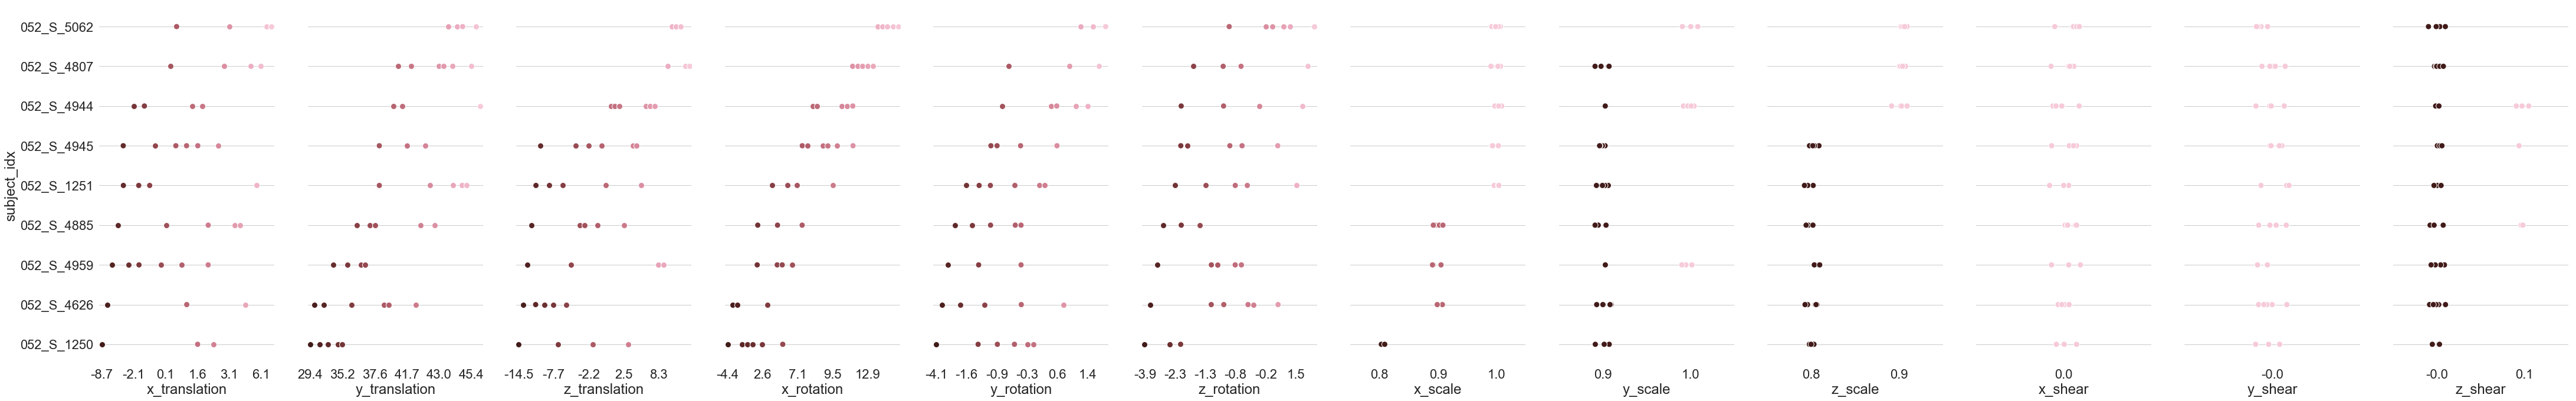

In [5]:
# Load the output df
dash_df = pd.read_pickle('/Users/nikhil/Downloads/test_dash_output.pkl')
plot_df = dash_df[dash_df['stx']=='stx'].copy()
plot_df[reg_cols] = plot_df[reg_cols].round(1)
sns.set(style="whitegrid",font_scale=2)
g = sns.PairGrid(plot_df,
                 x_vars=plot_df.columns[3:15], y_vars=["subject_idx"],
                 height=10, aspect=.5)

# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=10, orient="v",
      palette="ch:s=1,r=-.1,h=1_r", linewidth=1, edgecolor="w")

# Reduce the number of ticks for better visualization of pairgrid
max_labels = 5
for ax in g.axes.flat:    
    n_labels = len(ax.get_xticklabels())
    f = max([1,int(n_labels/max_labels)])
    for l,label in enumerate(ax.get_xticklabels()):
        label.set_visible(False)
        if l%f == 0:
            label.set_visible(True)

            
# Rotation works but not needed
#[plt.setp(ax.get_xticklabels(), rotation=90) for ax in g.axes.flat]

# Fancy ticker functions break the sns plotting ranges for pairgrid showing WRONG values
#[ax.xaxis.set_major_formatter(FormatStrFormatter('%5.2f')) for ax in g.axes.flat] 
#[ax.xaxis.set_major_locator(ticker.LinearLocator()) for ax in g.axes.flat] #Breaks the sns ranges for plotting

# Make the grid horizontal instead of vertical
for ax in g.axes.flat:
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)

# Identify outliers based on IQR 

In [26]:
dash_df = pd.read_pickle('/Users/nikhil/Downloads/test_dash_output.pkl')
reg_dirs = ['stx','stx2']
od_df = dash_df.copy()
df = find_reg_outliers(od_df,reg_dirs,reg_cols)

In [27]:
df[['subject_idx','tp','stx','outlier','outlier_param']]

subject_idx        tp   stx  outlier  \
0   052_S_1250  20080125  stx2    False   
0   052_S_1250  20080125   stx    False   
0   052_S_1250  20070228  stx2    False   
0   052_S_1250  20070228   stx    False   
0   052_S_1250  20070905  stx2    False   
0   052_S_1250  20070905   stx    False   
0   052_S_4626  20120403  stx2     True   
0   052_S_4626  20120403   stx    False   
0   052_S_4626  20120727  stx2    False   
0   052_S_4626  20120727   stx    False   
0   052_S_4626  20150415  stx2     True   
0   052_S_4626  20150415   stx     True   
0   052_S_4626  20121029  stx2    False   
0   052_S_4626  20121029   stx    False   
0   052_S_4626  20130429  stx2    False   
0   052_S_4626  20130429   stx    False   
0   052_S_4626  20140516  stx2     True   
0   052_S_4626  20140516   stx     True   
0   052_S_4959  20130918  stx2     True   
0   052_S_4959  20130918   stx    False   
0   052_S_4959  20130605  stx2    False   
0   052_S_4959  20130605   stx    False   
0   052_S_4959  20130304  stx2     True   
0   052_S_4959  20130304   stx     True   
0   052_S_4959  20140318  stx2    False   
0   052_S_4959  20140318   stx    False   
0   052_S_4885  20120810  stx2     True   
0   052_S_4885  20120810   stx     True   
0   052_S_4885  20130911  stx2    False   
0   052_S_4885  20130911   stx    False   
..         ...       ...   ...      ...   
0   052_S_4944  20130419  stx2     True   
0   052_S_4944  20130419   stx    False   
0   052_S_4944  20121019  stx2    False   
0   052_S_4944  20121019   stx     True   
0   052_S_4944  20140131  stx2     True   
0   052_S_4944  20140131   stx     True   
0   052_S_4944  20130710  stx2     True   
0   052_S_4944  20130710   stx     True   
0   052_S_4944  20150114  stx2     True   
0   052_S_4944  20150114   stx    False   
0   052_S_4807  20121019  stx2    False   
0   052_S_4807  20121019   stx     True   
0   052_S_4807  20120727  stx2    False   
0   052_S_4807  20120727   stx    False   
0   052_S_4807  20130215  stx2     True   
0   052_S_4807  20130215   stx    False   
0   052_S_4807  20150804  stx2     True   
0   052_S_4807  20150804   stx     True   
0   052_S_4807  20140807  stx2     True   
0   052_S_4807  20140807   stx     True   
0   052_S_4807  20130813  stx2     True   
0   052_S_4807  20130813   stx    False   
0   052_S_5062  20140422  stx2     True   
0   052_S_5062  20140422   stx     True   
0   052_S_5062  20130125  stx2    False   
0   052_S_5062  20130125   stx    False   
0   052_S_5062  20130612  stx2    False   
0   052_S_5062  20130612   stx    False   
0   052_S_5062  20130930  stx2    False   
0   052_S_5062  20130930   stx    False   

                                        outlier_param  
0                                                      
0                                                      
0                                                      
0                                                      
0                                                      
0                                                      
0                                      stx2_y_scale,   
0                                                      
0                                                      
0                                                      
0       stx2_y_rotation, stx2_y_scale, stx2_y_shear,   
0                       stx_y_rotation, stx_y_shear,   
0                                                      
0                                                      
0                                                      
0                                                      
0    stx2_x_rotation, stx2_z_rotation, stx2_z_shear,   
0       stx_x_rotation, stx_z_rotation, stx_x_shear,   
0                                stx2_y_translation,   
0                                                      
0                                                      
0                                                      
0                     stx2_z_rotation, stx2_x_sh